## Data-set up

In [128]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import numpy as np
from pandas import DataFrame
from sklearn.preprocessing import PowerTransformer, MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
from sklearn.metrics import classification_report,accuracy_score
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

projects = pd.read_csv("projects_cleaned.csv")
billing = pd.read_csv("billing_cleaned.csv")
branches_cleaned = pd.read_csv("branches_cleaned.csv")
employees_cleaned = pd.read_csv("employees_cleaned.csv")

In [129]:

# =================================================================== Datasets Merging + Feature Engineering  ====================================================================

billing = billing.merge(employees_cleaned, on='employee_id', how='left')

# --------------------------- Calculate total work hours ----------------------

# Aggregate total work hours per project
billing_agg = billing.groupby("project_key")["regular_hours"].sum().reset_index()
billing_agg.sort_values(by='regular_hours', ascending=True)

# --------------------------- Calculate duration in days ----------------------
# Calculate duration in days
project_timeframe = billing.groupby("project_key")["transfer_date"].agg(["min", "max"]).reset_index()
project_timeframe["min"] = project_timeframe["min"].astype(str)
project_timeframe["min"] = pd.to_datetime(project_timeframe["min"], format = '%Y-%m-%d')
project_timeframe["max"] = project_timeframe["max"].astype(str)
project_timeframe["max"] = pd.to_datetime(project_timeframe["max"], format = '%Y-%m-%d')
# plus one incase its just one day
project_timeframe["duration_days"] = (project_timeframe["max"] - project_timeframe["min"]).dt.days
project_timeframe["duration_days"] = project_timeframe["duration_days"].replace(0, 1)

# Aggregating a regular hours
total_hours_agg = billing.groupby("project_key")["regular_hours"].sum().reset_index()
total_hours_agg.rename(columns={"regular_hours": "total_hours"}, inplace=True)

# --------------------- Calculate Billable & Non-billable Hours -------------------- 

# Seperating Billable Hours
billable_hours_agg = billing[billing["category"] == "Billable"].groupby("project_key")["regular_hours"].sum().reset_index()
billable_hours_agg.rename(columns={"regular_hours": "billable_hours"}, inplace=True)

# Seperating Non-Billable Hours
non_billable_hours_agg = billing[billing["category"] != "Billable"].groupby("project_key")["regular_hours"].sum().reset_index()
non_billable_hours_agg.rename(columns={"regular_hours": "non_billable_hours"}, inplace=True)

# Merge all DataFrames
billable_vs_nonbillable_agg = total_hours_agg.merge(billable_hours_agg, on="project_key", how="left").merge(
    non_billable_hours_agg, on="project_key", how="left"
)
billable_vs_nonbillable_agg = billable_vs_nonbillable_agg.fillna(0)
billable_vs_nonbillable_agg

# Merging all 
hours_data = pd.merge(billable_vs_nonbillable_agg,project_timeframe, on="project_key", how = "left")

# Merge with project details
optimization_data= projects.merge(hours_data, on="project_key")
optimization_data = optimization_data.merge(branches_cleaned, on= "branch_id")

# --------------------------- Calculate Avg experience in years ----------------------
today = pd.to_datetime(datetime.today().date())
billing['termination_date'].fillna(today, inplace=True)

# Convert hire_date and termination_date to datetime
billing['hire_date'] = pd.to_datetime(billing['hire_date'])
billing['termination_date'] = pd.to_datetime(billing['termination_date'])

billing['experience_years'] = (billing['termination_date'] - billing['hire_date']).dt.days / 365

# ---------------------------- Calculate Count of Employee --------------------------

# Group by project_key and labour_category to get employee count & average experience
billing_number = billing.groupby(["project_key"]).agg(
    employee_count=('employee_id', 'nunique'),  # Unique employees per category
    avg_experience_years=('experience_years', 'mean'),  # Average experience
    avg_billing_cost=('rate', 'mean'),
    avg_target_ratio=('target_ratio', 'mean'),    # Average rate per category
).reset_index()

billing_number['avg_experience_years'].describe()

labour_employees = billing.groupby(["project_key", "labour_category"]).agg(
    employees=('employee_id', 'nunique')  # Sum of hours worked per category
).reset_index()

labour_employees = labour_employees.pivot(
    index='project_key', columns='labour_category', values='employees').reset_index()

billing_number = billing_number.merge(labour_employees, on='project_key')
billing_number.fillna(0, inplace=True) 

# merging with dataframe

optimization_data = optimization_data.merge(billing_number, on="project_key")
optimization_data.rename(columns={'employee_id': 'Employee_Count'}, inplace=True)

billing = pd.read_csv("billing_cleaned.csv")

# ----------------------- Calculate Frequency billing_frequency --------------------------

project_frequency = billing["project_key"].value_counts().reset_index()
project_frequency.columns = ["project_key", "billing_frequency"]

# merging 
optimization_data = optimization_data.merge(project_frequency, on="project_key")

# ------------------------- Calculate avg_projects_per_employee --------------------------

employee_project_count = billing.groupby(["employee_id", "transfer_date"])["project_key"].nunique().reset_index()
employee_project_count.rename(columns={"project_key": "num_projects_per_day"}, inplace=True)

# Step 2: Merge back to original dataset to assign each record the number of projects the employee was handling on that day
df = billing.merge(employee_project_count, on=["employee_id", "transfer_date"], how="left")

# Step 3: Compute the average number of projects each employee worked on per project
avg_projects_per_project = df.groupby("project_key")["num_projects_per_day"].mean().reset_index()
avg_projects_per_project.rename(columns={"num_projects_per_day": "avg_projects_per_employee"}, inplace=True)

optimization_data = optimization_data.merge(avg_projects_per_project, on="project_key")

# ------------------------- Calculate time_between_billings --------------------------
# adding the days in between transfer_date

# Ensure 'transfer_date' is in datetime format
billing['transfer_date'] = pd.to_datetime(billing['transfer_date'], errors='coerce')

# Sort by project and transfer_date to ensure correct ordering
billing = billing.sort_values(by=['project_key', 'transfer_date'])

# Calculate the time difference between consecutive billings for each project
billing['time_between_billings'] = billing.groupby('project_key')['transfer_date'].diff().dt.days

# Fill NaN values (first entry per group) with 0
billing['time_between_billings'] = billing['time_between_billings'].fillna(1).replace(0,1)

billing['Merge'] = billing['transfer_date'].astype(str) + ' ' + billing['project_key'].astype(str)
billing = billing.drop_duplicates(subset=['Merge'])
billing_grouping = billing.groupby('project_key').mean('time_between_billings').reset_index()
billing_grouping

#merging

optimization_data = optimization_data.merge(billing_grouping[['time_between_billings','project_key']], on="project_key")

# ------------------------- Calculate Engineer vs Other Count --------------------------

optimization_data["Count of Non-Engineer"] = optimization_data['Administration Finance & HR'] +  optimization_data['Communications IT & Design'] +  optimization_data['Environmental Health & Safety']+optimization_data['Field Surveying & Geomatics']+optimization_data['Landscape Architecture']+optimization_data['Planning']+optimization_data['Project Management & Consulting']

optimization_data = optimization_data.drop(columns=['Project Management & Consulting','Planning','Landscape Architecture','Field Surveying & Geomatics','Communications IT & Design','Environmental Health & Safety','Administration Finance & HR'])

optimization_data.rename(columns={
    "Engineering & Technical": "engineering_technical_employees",
    "Count of Non-Engineer": "other_employees"
}, inplace=True)


# -------------- Calculating contribution_ratio &  avg_target_ratio -----------------

optimization_data["contribution_ratio"] = (optimization_data['avg_target_ratio'].replace(0,1)/optimization_data['avg_projects_per_employee'].replace(0,1))/100
optimization_data['avg_target_ratio'] = optimization_data['avg_target_ratio']/100

# ----------------------------- Calculating Seasonality  -----------------------------


optimization_data['Start-Month'] = optimization_data['min'].dt.month

# First, use your existing function to create the season column
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

optimization_data['season'] = optimization_data['Start-Month'].apply(get_season)




/var/folders/dv/fxxthl6j34z_921cs3vs3jkw0000gn/T/ipykernel_6503/3815262754.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  billing['termination_date'].fillna(today, inplace=True)


# Creating Bins

/var/folders/dv/fxxthl6j34z_921cs3vs3jkw0000gn/T/ipykernel_6503/3258159238.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


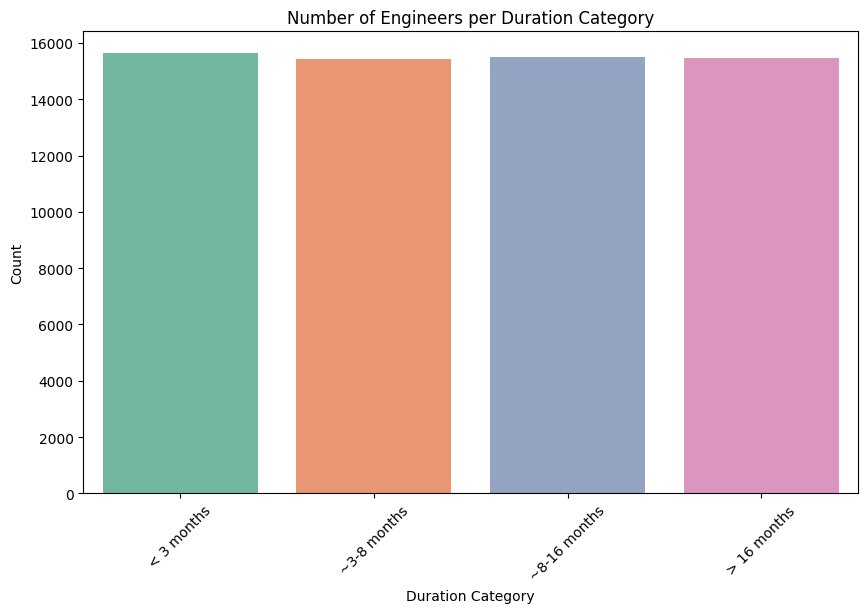

In [130]:

# Create duration bins using quantiles
optimization_data['duration'] = pd.qcut(
    optimization_data['duration_days'], 
    4, 
    labels=['< 3 months', '~3-8 months', '~8-16 months', '> 16 months']
)

# Bar plot for number of engineers per duration category
plt.figure(figsize=(10, 6))
sns.barplot(
    x=optimization_data['duration'].value_counts().index, 
    y=optimization_data['duration'].value_counts().values, 
    palette="Set2"
)
plt.xlabel("Duration Category")
plt.ylabel("Count")
plt.title("Number of Engineers per Duration Category")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

## Assumptions

In [131]:

# Looking at only inactive (completed) projects & Have had positive total hours > 0 and 
optimization_data['status'] = optimization_data['status'].astype(str)
optimization_data = optimization_data[(optimization_data["billable_hours"] > 0) & (optimization_data["status"] == "Inactive")]

In [132]:
# checking for multicollinearity
numeric_X = optimization_data.select_dtypes(include=['number']) 
numeric_X = numeric_X.drop(columns=['non_billable_hours','total_hours','employee_count','project_key','duration_days','avg_billing_cost','avg_target_ratio'])
X= numeric_X

pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

billable_hours                     4.533467
avg_experience_years               4.741455
engineering_technical_employees    3.015359
billing_frequency                  6.269355
avg_projects_per_employee          5.878602
time_between_billings              1.245239
other_employees                    2.806955
contribution_ratio                 3.082274
Start-Month                        4.113421
dtype: float64

In [133]:
# Dropping not needed columns
optimization_data = optimization_data.drop(columns=['project_key','season','status','avg_target_ratio','total_hours','employee_count','Start-Month','avg_billing_cost','min','max','project_leader','project_coordinator','branch_id','non_billable_hours',])

## Normalization and Standardization & Data-split

*Understanding the current distrubition of each variable*

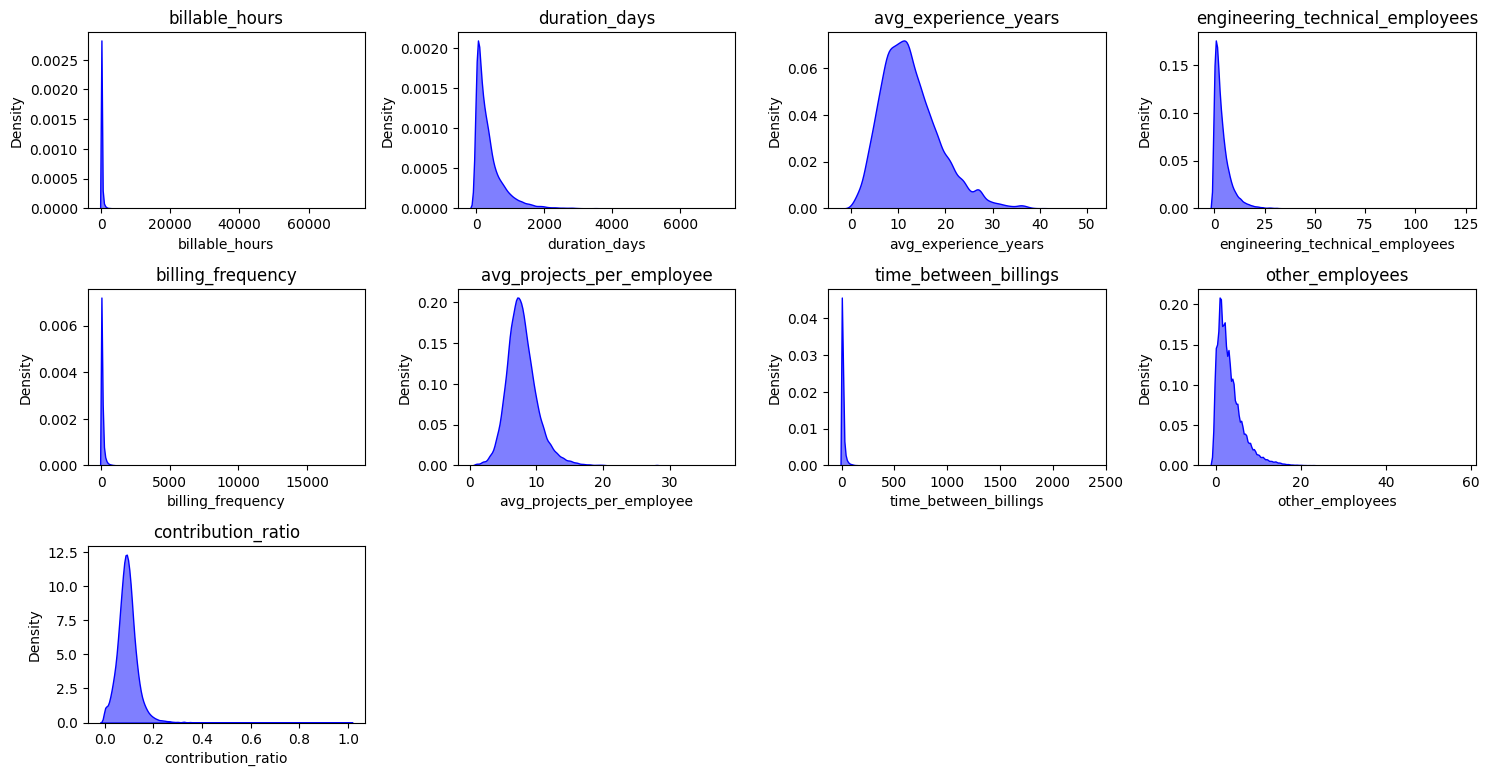

In [134]:

numerical_cols = optimization_data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = optimization_data.select_dtypes(include=['object']).columns
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 4, i)  # Adjust grid size based on number of variables
    sns.kdeplot(optimization_data[col], fill=True, color="blue", alpha=0.5)
    plt.title(col)

plt.tight_layout()
plt.show()

*Testing Siginificance*

In [135]:

# ============================================ Testing Significant Categororical Variables w/ Chisq =================================================

# Ho = Statistically Insiginificant p > 0.05 
# Ha = Statistically Significant p < 0.05 

# List of categorical variables to test
categorical_vars = ['project_type', 'source', 'branch_name']


def chi_square_test(df, cat_var, target_var='duration'):
    # Create contingency table
    contingency_table = pd.crosstab(df[cat_var], df[target_var])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Calculate Cramer's V for effect size
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))
    
    return {
        'variable': cat_var,
        'chi_square': chi2,
        'p_value': p_value,
        'degrees_of_freedom': dof,
        'cramers_v': cramers_v,
        'significant': p_value < 0.05
    }

results = []
for var in categorical_vars:
    result = chi_square_test(optimization_data, var)
    results.append(result)

# dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('p_value')

# Print results
print("Chi-Square Test Results for Categorical Variables vs. duration:")
print(results_df[['variable', 'chi_square', 'p_value', 'cramers_v', 'significant']])

Chi-Square Test Results for Categorical Variables vs. duration:
       variable  chi_square        p_value  cramers_v  significant
0  project_type  978.938057  1.278305e-162   0.091220         True
2   branch_name  932.600919  2.537919e-162   0.089035         True
1        source  162.386251   1.849179e-32   0.045502         True


*Splitting Dataset, normalizing and standardizing*

In [136]:

X = optimization_data.drop(columns=['duration','duration_days']) # Features
y = optimization_data['duration'] # Target

# Identify categorical and numeric columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [137]:


# Remove constant features (zero variance) before transformation
constant_features = [col for col in numeric_features if X_train[col].nunique() == 1]
numeric_features = [col for col in numeric_features if col not in constant_features]

# Define the pipeline with separate handling for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('power', PowerTransformer(method='yeo-johnson')),  # Normalize
    ('standard', StandardScaler()),  # Standardize
    ('minmax', MinMaxScaler(feature_range=(1, 2)))  # Scale between 1 and 2
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))  # One-hot encode categorical variables
])

# Combine transformations into a single column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    verbose_feature_names_out=False  # This helps with naming
)

# Apply transformations to the training and testing data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Get feature names after transformation
transformed_feature_names = preprocessor.get_feature_names_out()

# Check dimensions
print("Transformed X_train shape:", X_train_transformed.shape)
print("Number of transformed feature names:", len(transformed_feature_names))

# Convert the transformed data to DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)

print("Successfully created transformed DataFrames!")


Transformed X_train shape: (27450, 49)
Number of transformed feature names: 49
Successfully created transformed DataFrames!


<Figure size 1500x1000 with 0 Axes>

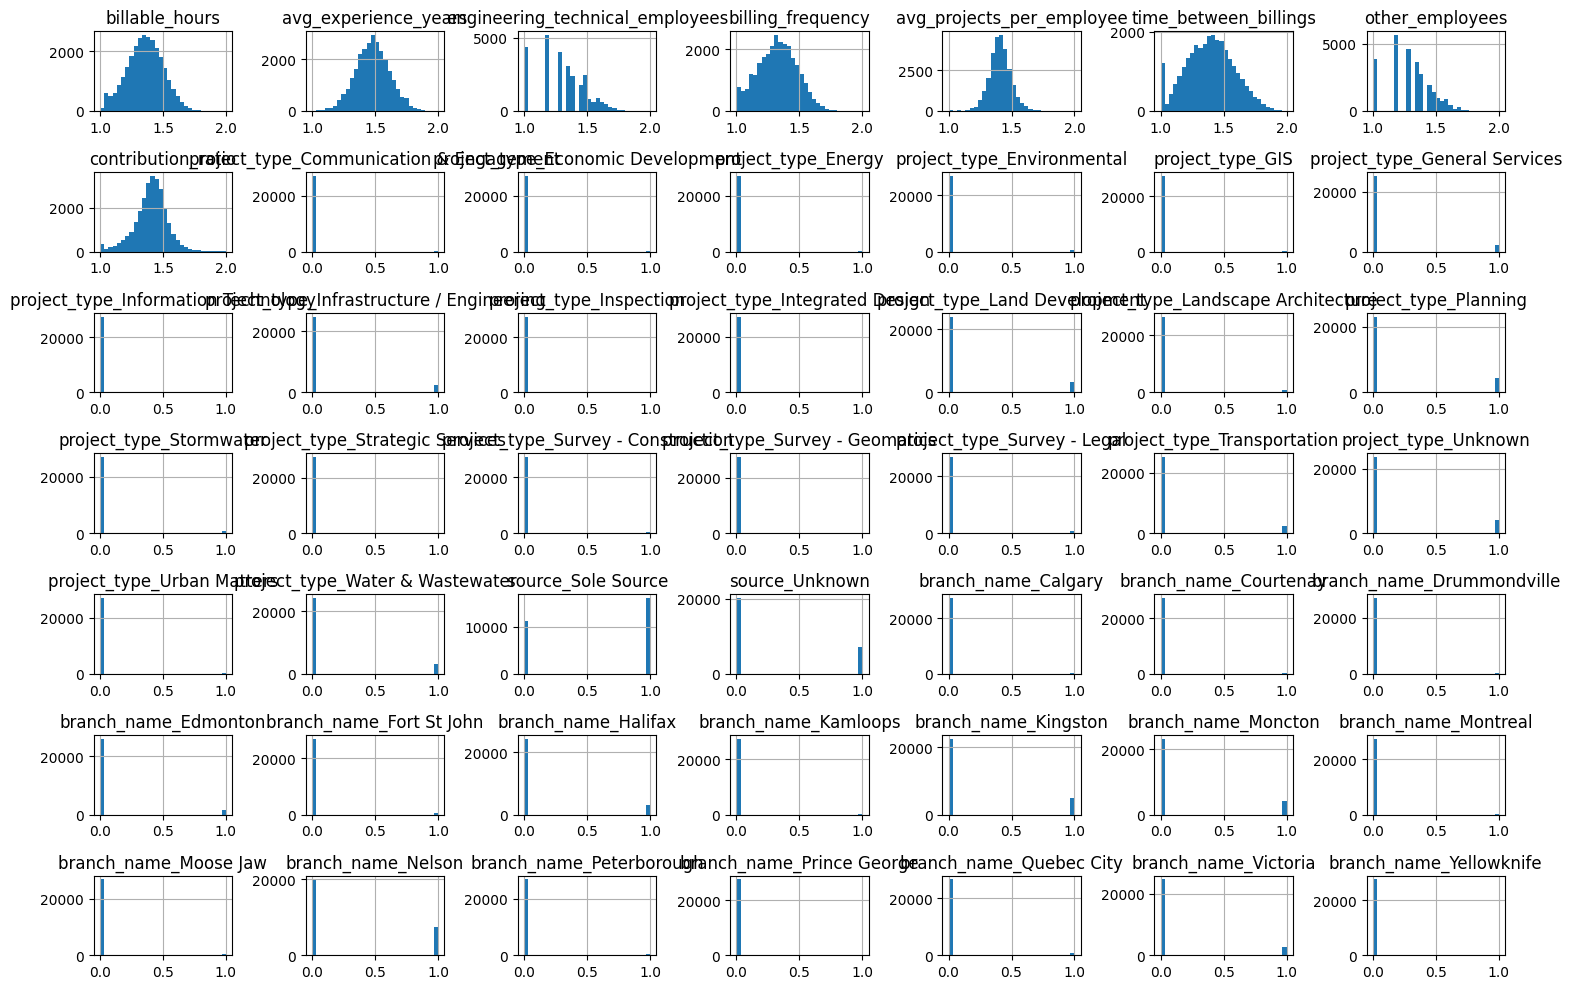

In [138]:

plt.figure(figsize=(15, 10))
X_train_transformed_df.hist(bins=30, figsize=(15, 10)) 
plt.tight_layout()
plt.show()


## Model 1: Random Forest Classifier

In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score

# Initialize the classifier
model = RandomForestClassifier(random_state=42)

# Fit the model on the training data
model.fit(X_train_transformed, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_transformed)

# Evaluate the model
print(classification_report(y_test, y_pred))

acc = accuracy_score(y_test, y_pred)
acc

              precision    recall  f1-score   support

  < 3 months       0.97      0.91      0.94      2371
 > 16 months       0.88      0.86      0.87      2801
 ~3-8 months       0.84      0.86      0.85      3198
~8-16 months       0.78      0.82      0.80      3395

    accuracy                           0.86     11765
   macro avg       0.87      0.86      0.87     11765
weighted avg       0.86      0.86      0.86     11765



0.8579685507862304

## RFC - Bayes Search CV

In [140]:

param_space = {
    'n_estimators': (10, 500),          # Number of trees in the forest (integer range)
    'max_depth': (3, 50),               # Maximum depth of the tree (integer range)
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider at every split
    'min_samples_split': (2, 10),       # Minimum number of samples required to split an internal node (integer range)
    'min_samples_leaf': (1, 10)         # Minimum number of samples required to be at a leaf node (integer range)
}

rf = RandomForestClassifier(random_state=42)

# Set up the BayesSearchCV; here, n_iter specifies the number of parameter settings that are sampled.
bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space,
    n_iter=32,            # Total number of iterations (adjust based on your time/complexity requirements)
    cv=3,                 # 3-fold cross-validation
    scoring='accuracy',   # Evaluation metric
    random_state=42
)

# Run the Bayesian optimization
bayes_search.fit(X_train_transformed, y_train)

# Print the best parameters and best score
print("Best Parameters:", bayes_search.best_params_)
print("Best Cross-Validation Accuracy:", bayes_search.best_score_)

# Testing on the best paramters
test_score = bayes_search.score(X_test_transformed, y_test)
print("Test Accuracy:", test_score)

/Users/maryamahmed/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/maryamahmed/Library/Python/3.9/lib/python/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(46), np.str_('sqrt'), np.int64(1), np.int64(2), np.int64(500)] before, using random point [np.int64(15), 'sqrt', np.int64(1), np.int64(2), np.int64(90)]
  warnings.warn(


Best Parameters: OrderedDict([('max_depth', 17), ('max_features', None), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 500)])
Best Cross-Validation Accuracy: 0.8816029143897998
Test Accuracy: 0.8785380365490862


In [141]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score

# Initialize the classifier
model = RandomForestClassifier(random_state=42, max_depth=28,max_features=None,min_samples_leaf=1,min_samples_split=2,n_estimators=500)

# Fit the model on the training data
model.fit(X_train_transformed, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_transformed)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

  < 3 months       0.96      0.94      0.95      2371
 > 16 months       0.88      0.90      0.89      2801
 ~3-8 months       0.88      0.87      0.87      3198
~8-16 months       0.82      0.83      0.83      3395

    accuracy                           0.88     11765
   macro avg       0.89      0.88      0.89     11765
weighted avg       0.88      0.88      0.88     11765



# Support Vector Machine

In [142]:
from skopt.space import Real, Categorical
svm_model = SVC()

# Define the parameter search space
param_space = {
    'C': Real(0.001, 1000, prior='log-uniform'),
    'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': Categorical(['scale', 'auto'])
}

# Perform Bayesian Search
bayes_search = BayesSearchCV(
    svm_model,
    param_space,
    n_iter=30,  # Number of iterations
    scoring='accuracy',  # Optimize for accuracy
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    random_state=42
)

# Fit the Bayesian search
bayes_search.fit(X_train_transformed, y_train)

# Get the best parameters
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)

# Train SVM with best params
best_svm = SVC(**best_params)
best_svm.fit(X_train_transformed, y_train)

# Predict
y_pred = best_svm.predict(X_test_transformed)

# Evaluate Model
print("Test accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Hyperparameters: OrderedDict([('C', 1000.0), ('gamma', 'auto'), ('kernel', 'rbf')])
Test accuracy:  0.885252868678283
Classification Report:
               precision    recall  f1-score   support

  < 3 months       0.96      0.95      0.95      2371
 > 16 months       0.89      0.90      0.90      2801
 ~3-8 months       0.89      0.87      0.88      3198
~8-16 months       0.83      0.84      0.84      3395

    accuracy                           0.89     11765
   macro avg       0.89      0.89      0.89     11765
weighted avg       0.89      0.89      0.89     11765



## Logistic Regression

In [148]:


log_model = LogisticRegression(class_weight='balanced',max_iter=1000,multi_class='multinomial' )
log_model.fit(X_train_transformed, y_train)

y_pred_logic = log_model.predict(X_test_transformed)
report = classification_report(y_test, y_pred_logic)
print(report)


/Users/maryamahmed/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

  < 3 months       0.95      0.93      0.94      2371
 > 16 months       0.86      0.89      0.87      2801
 ~3-8 months       0.86      0.85      0.86      3198
~8-16 months       0.80      0.80      0.80      3395

    accuracy                           0.86     11765
   macro avg       0.87      0.87      0.87     11765
weighted avg       0.86      0.86      0.86     11765



In [150]:

coefficients = log_model.coef_

# Getting feature names (if they exist, otherwise use generic names)
if isinstance(X_train_transformed, pd.DataFrame):
    feature_names = X_train_transformed.columns
else:
    feature_names = [f"Feature {i}" for i in range(X_train_transformed.shape[1])]

# Combine feature names and coefficients into a DataFrame for easier reading
coef_df = pd.DataFrame(coefficients.T, columns=log_model.classes_, index=feature_names)
print(coef_df)

            < 3 months  > 16 months  ~3-8 months  ~8-16 months
Feature 0    -9.706210     9.122682    -2.868329      3.451857
Feature 1    -0.127052     0.593374    -0.203302     -0.263019
Feature 2    -0.044842    -0.105994     0.159189     -0.008352
Feature 3   -33.381109    34.825291   -11.530662     10.086479
Feature 4    -2.025496     2.754983    -1.286165      0.556679
Feature 5   -28.332886    30.077116   -10.228136      8.483906
Feature 6    -0.096154     0.222254    -0.080428     -0.045672
Feature 7    -0.442984     0.662917    -0.424185      0.204252
Feature 8     0.420703    -0.254630     0.166507     -0.332580
Feature 9    -0.270669     0.221027    -0.002445      0.052086
Feature 10    0.077191     0.184156    -0.235207     -0.026140
Feature 11    0.127757    -0.029334     0.037393     -0.135817
Feature 12    0.074849     0.315096    -0.384020     -0.005926
Feature 13    0.341250    -0.327152    -0.040395      0.026297
Feature 14    0.000906     0.684902    -0.077811     -0

## Comparison

/Users/maryamahmed/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/maryamahmed/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


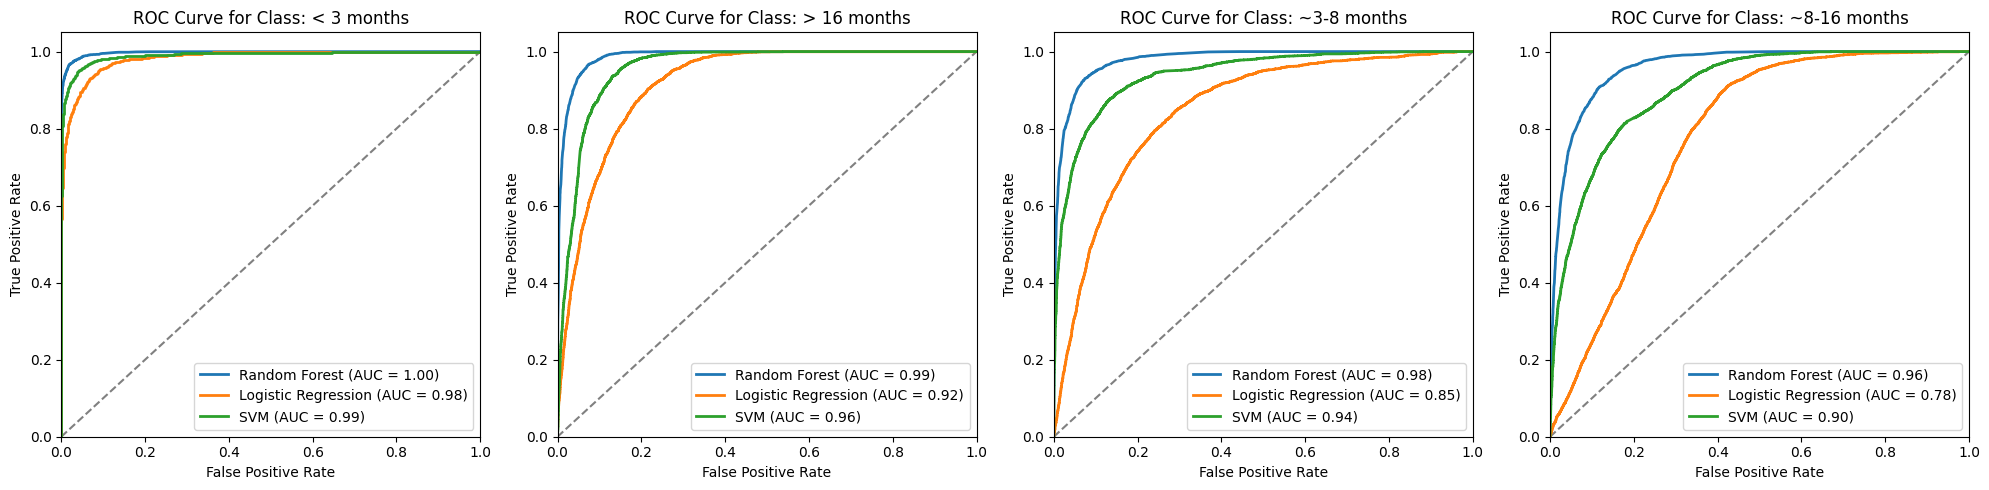

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

models = {
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, max_depth=28, max_features=None, min_samples_leaf=1, n_estimators=500))
    ]),
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs', max_iter=1000))
    ]),
    "SVM": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(C=1000, gamma='auto', kernel='rbf', probability=True))
    ])
}

if y_train.dtype == 'object' or y_train.dtype.name == 'category':
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    classes = label_encoder.classes_
else:
    y_train_encoded = y_train
    y_test_encoded = y_test
    classes = np.unique(y_train)

n_classes = len(classes)

# Binarize the test labels
y_test_bin = label_binarize(y_test_encoded, classes=np.arange(n_classes))

# Create one subplot for each class
fig, axes = plt.subplots(1, n_classes, figsize=(5*n_classes, 5), squeeze=False)
axes = axes.flatten()

# Fit all models once
fitted_models = {}
for name, model in models.items():
    model.fit(X_train, y_train_encoded)
    fitted_models[name] = model

# Plot ROC curves for each class separately
for i, cls in enumerate(classes):
    axes[i].plot([0, 1], [0, 1], color='grey', linestyle='--')
    
    # Loop through models
    for name, model in fitted_models.items():
        # Check if there are enough positive and negative samples
        if np.sum(y_test_bin[:, i]) == 0 or np.sum(y_test_bin[:, i]) == len(y_test_bin[:, i]):
            print(f"Skipping class {cls} for {name} because of insufficient positive/negative samples in y_test")
            continue
        
        # Get predictions for this class
        y_scores = model.predict_proba(X_test)[:, i]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores)
        roc_auc = auc(fpr, tpr)
        
        # Plot the curve
        axes[i].plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
    
    # Set up the subplot
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'ROC Curve for Class: {cls}')
    axes[i].legend(loc='lower right')

plt.tight_layout()
plt.show()

Citation: https://claude.ai/chat/0b458e7f-1eb4-4014-8429-76725654faaf